# Fit a model for the growth of yeast cells

This notebook uses the [rOMERO-gateway](https://github.com/ome/rOMERO-gateway) and [EBImage](http://bioconductor.org/packages/release/bioc/html/EBImage.html) to process an Image associated to the paper ['Timing of gene expression in a cell-fate decision system'](https://doi.org/10.17867/10000114).

The Image "Pos22" is taken from the dataset [idr0040-aymoz-singlecell/experimentA/YDA306_AGA1y_PRM1r_Mating](https://idr.openmicroscopy.org/webclient/?show=image-3491334).
It is a timelapse Image with 42 timepoints separated by 5 minutes.
This Image is used to fit a model for the growth of the yeast cells. The notebook does not replicate any of the analysis of the above mentioned paper.

Load R gateway and connect to server:

In [1]:
library(romero.gateway)
library(EBImage)
server <- OMEROServer(host = 'idr.openmicroscopy.org', port = as.integer(4064), username = 'public', password = 'public')
server <- connect(server)

Loading required package: rJava
Loading required package: jpeg

*** Welcome to rOMERO 0.4.0 (~ OMERO 5.4.6) ***


Attaching package: ‘EBImage’

The following object is masked from ‘package:romero.gateway’:

    Image



Load the image:

In [2]:
# YDA306_AGA1y_PRM1r_Mating - Pos22 
imageId <- 3491334
image <- loadObject(server, "ImageData", imageId)

Found more than one class "Image" in cache; using the first, from namespace 'romero.gateway'
Also defined by ‘EBImage’


Just set some information about the image:

In [3]:
tmax <- 42  # number of timepoints
tInMinutes <- 5  # separation between timepoints in minutes

Get the raw pixel values of the image. We use only the second (CFP labelled) channel, because that nicely shows the
single, separated cells. Use an image from the middle of the timelapse, which hopefully provides a representative image of the whole timelapse.

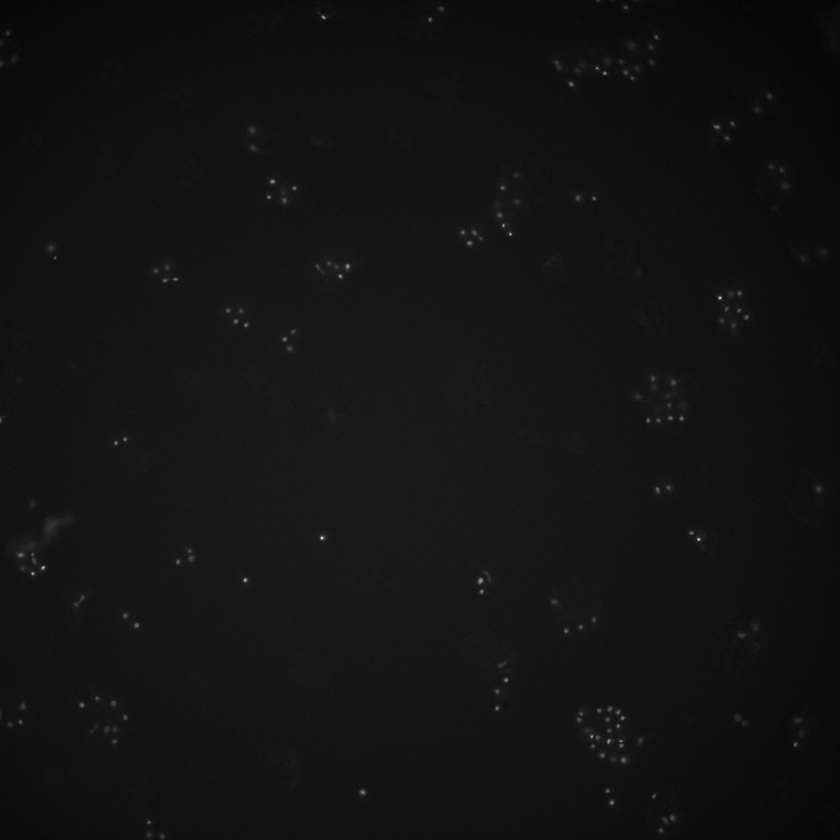

In [4]:
t <- as.integer(tmax / 2)
pixels <- getPixelValues(image, 1, t, 2)
ebi <- EBImage::Image(data = pixels, colormode = 'Grayscale')
img <- normalize(ebi)
EBImage::display(img)

Now threshold the image in order to separate the cells from the background and from each other. Play around a bit with the parameters to get a good result.

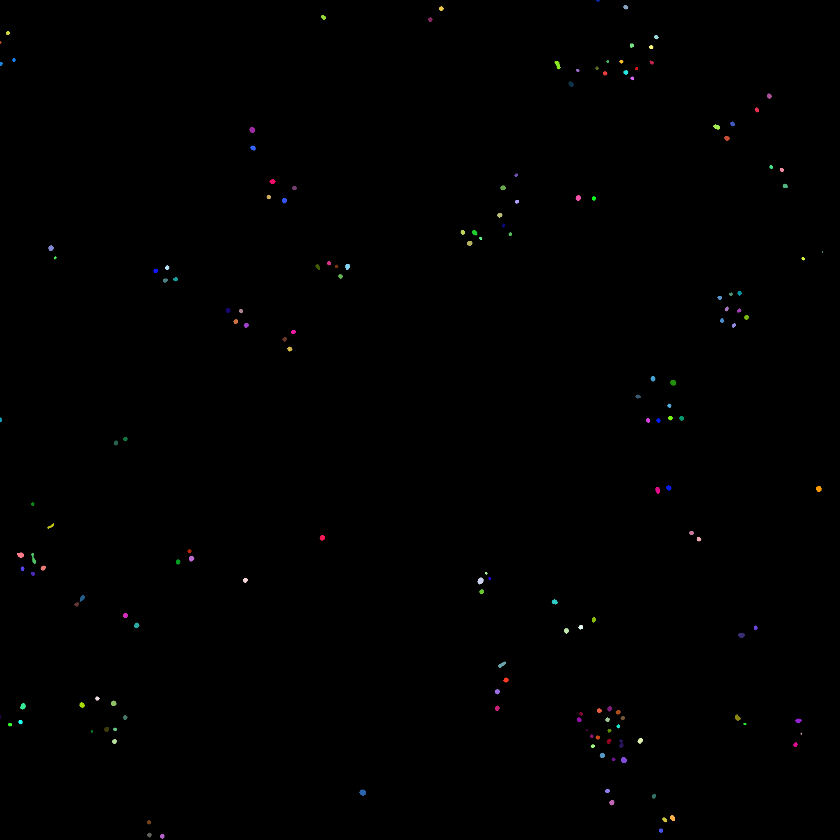

In [5]:
threshImg = thresh(img, w=20, h=20, offset=0.05)
threshImg <- medianFilter(threshImg, 3)
threshImg = fillHull(threshImg)
threshImg = bwlabel(threshImg)
EBImage::display(colorLabels(threshImg))

Count the cells on that image:

In [6]:
count <- range(threshImg)
count[2]

[1] 171

Wrap it all up in a function:

In [7]:
countCells <- function (t) {
  pixels <- getPixelValues(image, 1, t, 2)
  ebi <- EBImage::Image(data = pixels, colormode = 'Grayscale')
  img <- normalize(ebi)
  threshImg = thresh(img, w=20, h=20, offset=0.05)
  threshImg <- medianFilter(threshImg, 3)
  threshImg = fillHull(threshImg)
  threshImg = bwlabel(threshImg)
  count <- range(threshImg)
  count[2]
}

Iterate through the timepoints and store the cell count in a dataframe (warning: this can take **up to 20 min**, use 'seq(1,tmax,7)' to only analyse every seventh image for a quick run):

In [8]:
df <- data.frame(TimePoint=integer(),
                 CellCount=integer())

for (t in (1:tmax)) {
#for (t in seq(1,tmax,7)) { # use seq(1,tmax,7) to only use every seventh image (faster)
  count <- countCells(t)
  time <- (t * tInMinutes)
  df <- rbind(df, c(time, count))
}

names(df) <- c("TimePoint", "CellCount")
df

TimePoint,CellCount
5,114
10,116
15,120
20,126
25,128
30,134
35,136
40,137
45,135
50,140


Plot the cell counts:

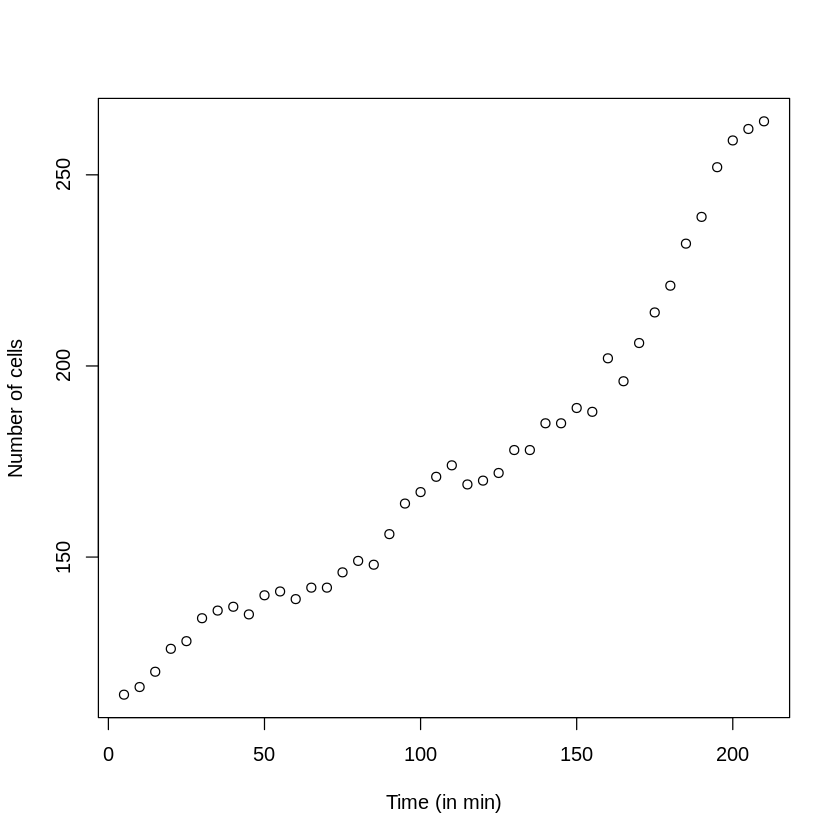

In [9]:
plot(df$TimePoint, df$CellCount, ylab = "Number of cells", xlab = "Time (in min)")

Fit an exponential model:

In [10]:
model <- lm(log(df$CellCount)~ df$TimePoint)
print(summary(model))



Call:
lm(formula = log(df$CellCount) ~ df$TimePoint)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.07017 -0.03106 -0.01024  0.02787  0.08196 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.7270953  0.0128543   367.7   <2e-16 ***
df$TimePoint 0.0037388  0.0001042    35.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04091 on 40 degrees of freedom
Multiple R-squared:  0.9699,	Adjusted R-squared:  0.9691 
F-statistic:  1288 on 1 and 40 DF,  p-value: < 2.2e-16



$$\rightarrow N = e^{\:4.72710\:+\:0.00374\:*\:t}\:;\:\text{where N is the number of cells at time t}$$

Very good fit: p-Values < 2e-16, and 97% of the variation is explained by the model!

Lets show that on the plot

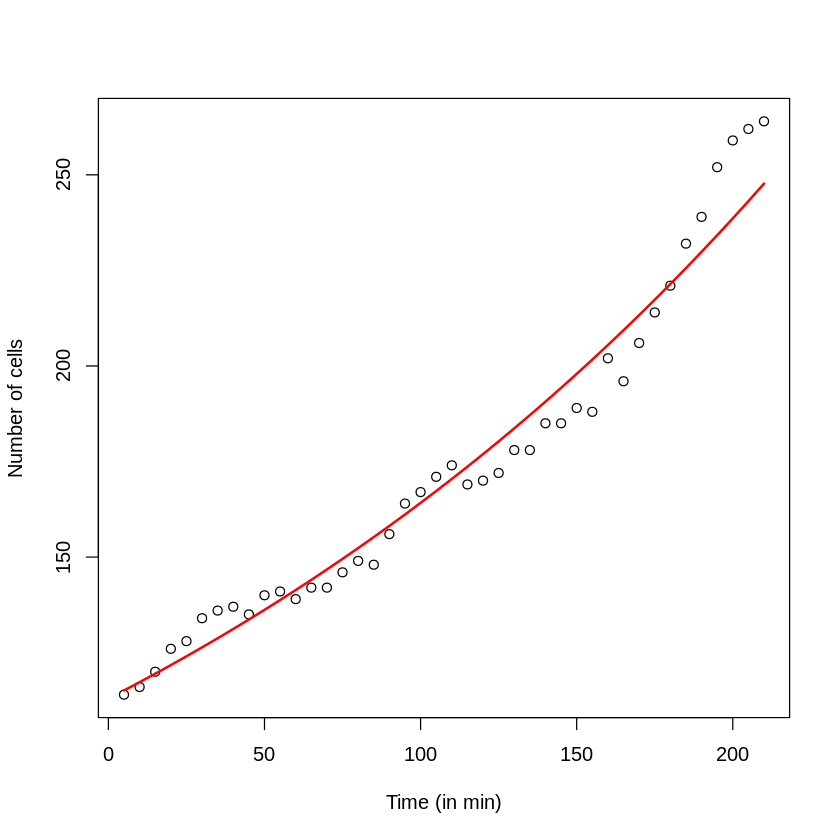

In [11]:
plotTime <- as.list(df[,1])
predCounts <- exp(predict(model,plotTime))
plot(df$TimePoint, df$CellCount, ylab = "Number of cells", xlab = "Time (in min)")
lines(plotTime, predCounts,lwd=2, col = "red")

Finally disconnect from the server again:

In [12]:
disconnect(server)

### License

Copyright (C) 2018 University of Dundee. All Rights Reserved.

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.